Did not converge in 10000000 trials


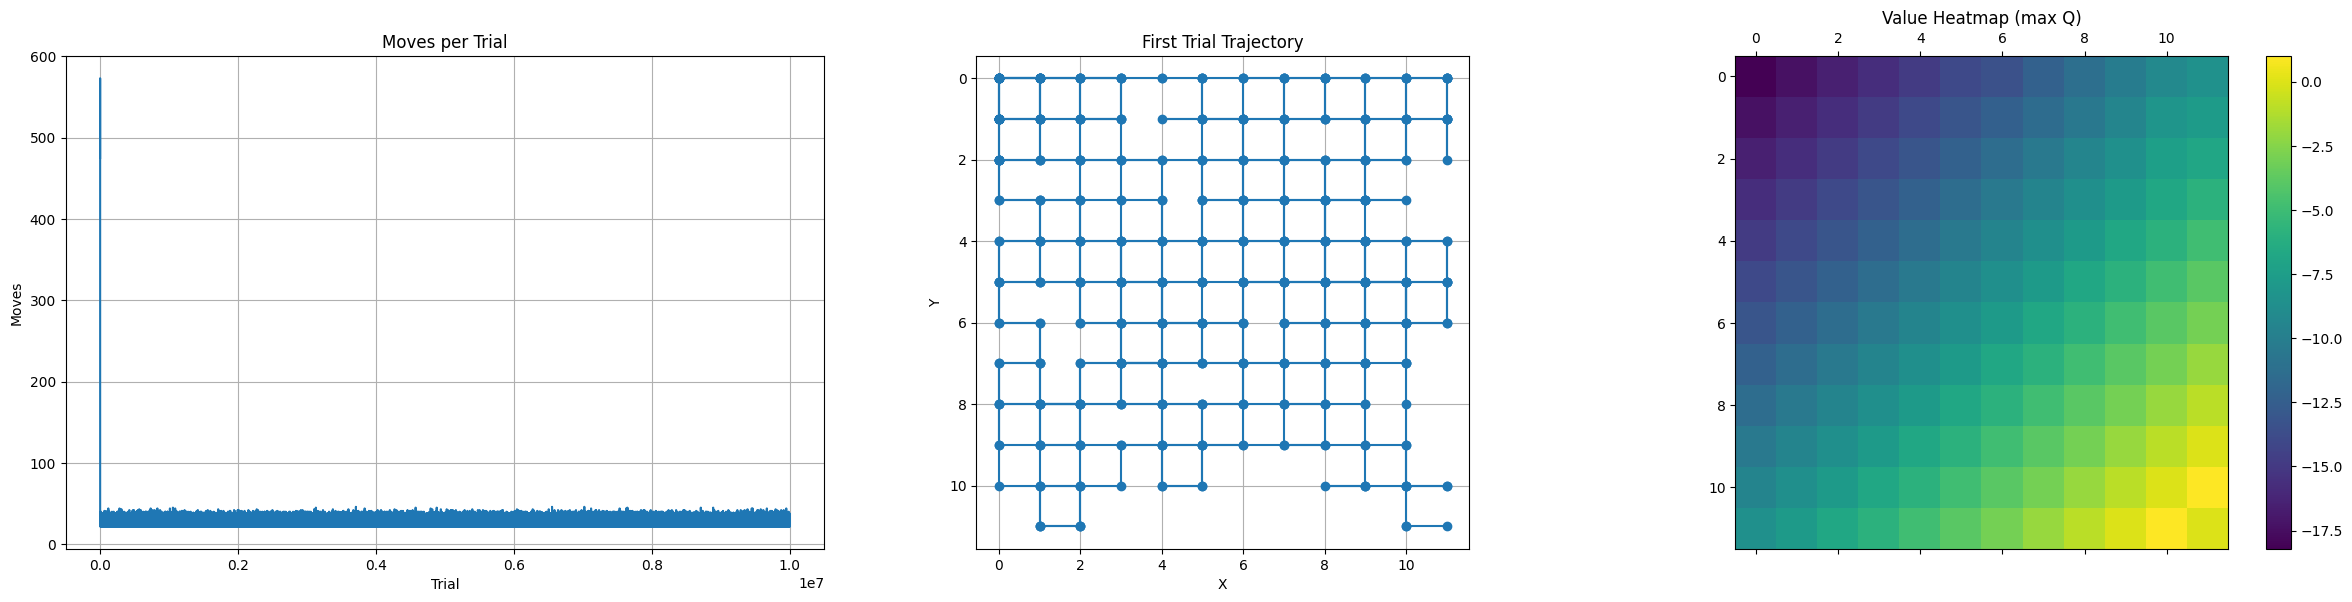

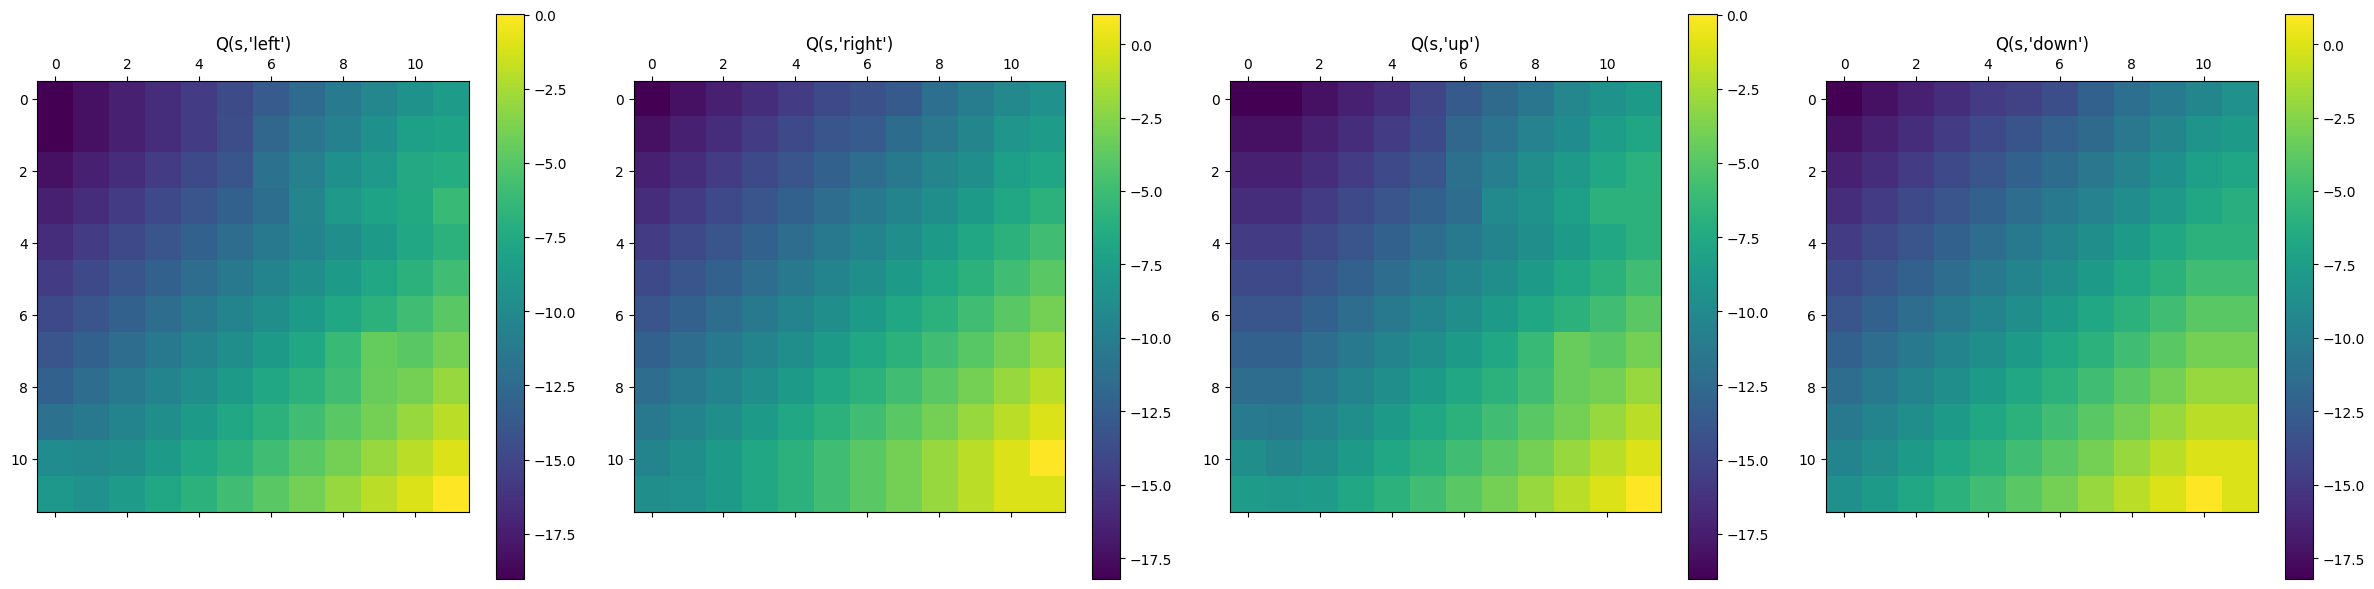

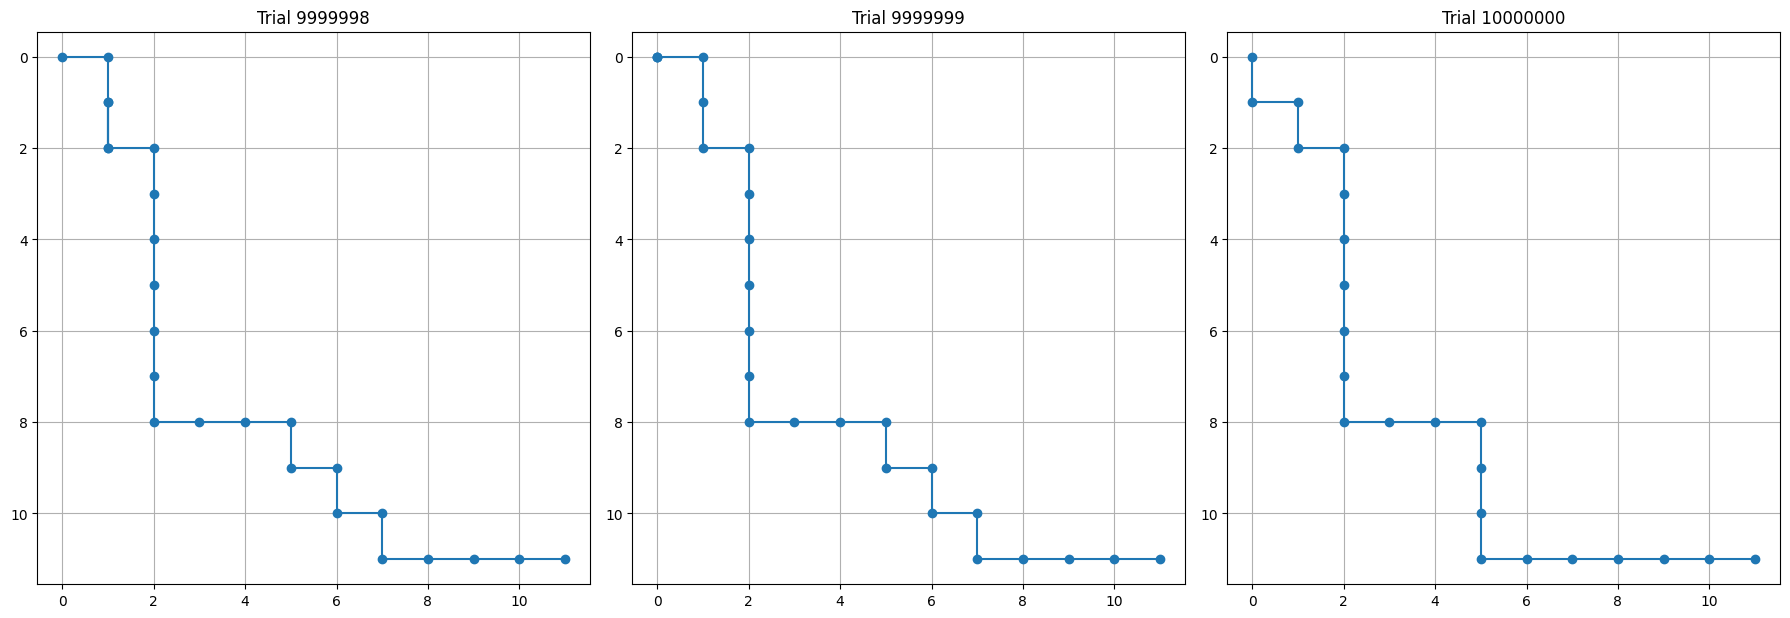

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# ─── Parameters ────────────────────────────────────────────────────────────────
grid_size       = 12     # ⟵ you changed it to 12
num_states      = grid_size * grid_size
actions         = ['left', 'right', 'up', 'down']
num_actions     = len(actions)
alpha           = 0.1
gamma           = 0.99
epsilon         = 0.1
tau             = 1.0
lambda_         = 0.9
max_trials      = 10000000
softmax_policy  = False
criterion_moves = 20
min_successes   = 5
# ────────────────────────────────────────────────────────────────────────────────

def state_to_pos(s): return divmod(s, grid_size)
def pos_to_state(r, c): return r * grid_size + c

def take_action(s, a):
    r, c = state_to_pos(s)
    if a=='left':  c = max(0, c-1)
    if a=='right': c = min(grid_size-1, c+1)
    if a=='up':    r = max(0, r-1)
    if a=='down':  r = min(grid_size-1, r+1)
    return pos_to_state(r, c)

def select_eps(s):
    if random.random() < epsilon:
        return random.randrange(num_actions)
    return int(np.argmax(Q[s]))

def select_soft(s):
    q = Q[s]
    m = q.max()
    e = np.exp((q-m)/tau)
    p = e / e.sum()
    return int(np.random.choice(num_actions, p=p))

# ─── Initialize Q, traces, bookkeeping ─────────────────────────────────────────
Q = np.random.uniform(0, 0.01, (num_states, num_actions))
E = np.zeros_like(Q)

start_state = 0
goal_state  = num_states - 1

moves_per_trial     = []
consecutive_success = 0
first_traj          = None
last_three_info     = []  # will hold tuples (trial_number, trajectory)
convergence_trial   = None
# ────────────────────────────────────────────────────────────────────────────────

for trial in range(1, max_trials+1):
    state = start_state
    moves = 0
    traj  = [state]
    E.fill(0)

    # pick first action
    action = select_soft(state) if softmax_policy else select_eps(state)

    while state != goal_state:
        next_state = take_action(state, actions[action])
        reward     = 1 if next_state==goal_state else -1

        greedy_next = int(np.argmax(Q[next_state]))
        delta       = reward + gamma * Q[next_state, greedy_next] - Q[state, action]

        E[state, action] += 1
        Q += alpha * delta * E
        E *= gamma * lambda_

        next_action = select_soft(next_state) if softmax_policy else select_eps(next_state)
        if next_action != greedy_next:
            E.fill(0)

        state, action = next_state, next_action
        traj.append(state)
        moves += 1

    moves_per_trial.append(moves)
    if trial == 1:
        first_traj = traj

    # record last three
    last_three_info.append((trial, traj.copy()))
    if len(last_three_info) > 3:
        last_three_info.pop(0)

    # check convergence
    if moves <= criterion_moves:
        consecutive_success += 1
        if consecutive_success >= min_successes:
            convergence_trial = trial
            print(f"Converged at trial {trial}")
            break
    else:
        consecutive_success = 0

if convergence_trial is None:
    print(f"Did not converge in {max_trials} trials")

# ─── Plot 1: Learning Curve / First Trajectory / Value Heatmap ───────────────
fig, ax = plt.subplots(1, 3, figsize=(24,6))

# Learning curve
ax[0].plot(moves_per_trial)
ax[0].set(title='Moves per Trial', xlabel='Trial', ylabel='Moves')
ax[0].grid(True)

# First-trial trajectory
xs, ys = zip(*[state_to_pos(s) for s in first_traj])
ax[1].plot(xs, ys, '-o')
ax[1].invert_yaxis(); ax[1].set_aspect('equal')
ax[1].set(title='First Trial Trajectory', xlabel='X', ylabel='Y')
ax[1].grid(True)

# Value function heatmap V(s)=max_a Q(s,a)
V = np.max(Q, axis=1).reshape((grid_size, grid_size)).T
cax = ax[2].matshow(V, cmap='viridis')
fig.colorbar(cax, ax=ax[2])
ax[2].set(title='Value Heatmap (max Q)')

plt.tight_layout()
plt.show()

# ─── Plot 2: Q-Value Heatmaps ─────────────────────────────────────────────────
fig2, ax2 = plt.subplots(1, num_actions, figsize=(24,6))
for i, act in enumerate(actions):
    H = Q[:,i].reshape((grid_size, grid_size)).T
    cax = ax2[i].matshow(H, cmap='viridis')
    ax2[i].set_title(f"Q(s,'{act}')")
    fig2.colorbar(cax, ax=ax2[i])
plt.tight_layout()
plt.show()

# ─── Plot 3: Last Three Trajectories ───────────────────────────────────────────
fig3, ax3 = plt.subplots(1, 3, figsize=(18,6))
for idx, (t_num, t_traj) in enumerate(last_three_info):
    xs, ys = zip(*[state_to_pos(s) for s in t_traj])
    ax3[idx].plot(xs, ys, '-o')
    ax3[idx].invert_yaxis(); ax3[idx].set_aspect('equal')
    ax3[idx].set(title=f'Trial {t_num}')
    ax3[idx].grid(True)
plt.tight_layout()
plt.show()